In [2]:
import numpy as np
import math
from scipy.optimize import minimize, SR1, Bounds, LinearConstraint

# Computer Experiments with Proximal Mirror Methods

In [3]:
def g_func(u, A, noise1, noise2):
    u1 = u[:n] + noise1
    u2 = u[n:] + noise2
    return np.concatenate((np.dot(A, u2), -np.dot(A.T, u1)), axis = None).reshape(n+m, 1)

def f(u):
    u1 = u[:n]
    u2 = u[n:] 
    return float(np.dot(u1.T, np.dot(A, u2)))

def obj_maxL(y, *args):
    x_fix, A = args
    return -float(np.dot(x_fix.T, np.dot(A, y))) 

def obj_minL(x, *args):
    y_fix, A = args
    return float(np.dot(x.T, np.dot(A, y_fix))) 

def regret(u, m, n, A, eps):
    x = u[:n]
    y = u[n:] 
    
    x_fix = np.copy(x)
    args_addit_max = (x_fix, A)
            
    bs = Bounds([0] * m, [1] * m)
    
    eq_cons1 = {'type': 'eq', 'fun' : lambda x: np.sum(x) - 1,
            'jac' : lambda x: np.array([1.0]*m)}
            
    max_res = minimize(obj_maxL, args = args_addit_max, x0 = np.ravel(y), method = 'trust-constr', bounds = bs, 
                       constraints = [eq_cons1], tol = eps, options={'gtol': eps, 'maxiter': maxit, 'verbose': 0})
    y_fix = np.copy(y)
    args_addit_min = (y_fix, A)
            
    bs = Bounds([0] * n, [1] * n)
    eq_cons2 = {'type': 'eq', 'fun' : lambda x: np.sum(x) - 1,
            'jac' : lambda x: np.array([1.0]*n)}    
    min_res = minimize(obj_minL, args = args_addit_min, x0 = np.ravel(x), method = 'trust-constr', bounds = bs, 
                                    constraints = [eq_cons2], tol = eps, options={'gtol': eps, 'maxiter': maxit, 'verbose': 0})
        
    
    return -obj_maxL(max_res.x, x_fix, A) - obj_minL(min_res.x, y_fix, A)

In [4]:
# Prox-function 
# z should be a vector, not a matrix (that's why np.ravel() is used)
def d(z, a):
    norm_z = np.linalg.norm(np.ravel(z), a)
    return 1/ 2 / (a - 1) * norm_z* norm_z

In [5]:
# Prox-function entropy
# z should be a vector, not a matrix (that's why np.ravel() is used)
def d_entropy(z, a):
    return sum([zi * math.log(abs(zi)) for zi in z])

In [6]:
# Gradient of prox-function 
def grad_d(z, a):
    dim = z.shape[0]
    g = np.zeros(dim).reshape(dim, 1)
    norm_z = np.linalg.norm(np.ravel(z), a)
    nzz = 1/ (a - 1)*pow(norm_z, 2 - a)
    for k in range(0, dim):
        g[k] = nzz * pow(abs(z[k]), a - 1)
        
    return g

In [7]:
# Gradient of entropy prox-function 
def grad_d_entropy(z, a):
    g = np.zeros(n_dim).reshape(n_dim, 1)
    for k in range(0, n_dim):
        g[k] = 1 + math.log(abs(z[k]))
        
    return g

In [8]:
# Gradient G(lambda) 
def grad_G(lam, a, c):
    z = np.zeros(n_dim).reshape(n_dim, 1)
    g = np.zeros(n_dim).reshape(n_dim, 1)
    
    t = pow(lam * a * (a - 1), 2 / (2 - a)) * pow(L, 2 / (a - 2))
    
    sum_z = 0
    for k in range(0, n_dim):
        z[k] = pow( abs(- c[k] / lam / a), 1 / (a - 1))
        sum_z = sum_z + pow(z[k], a)
        
    g = pow(t, a / 2) - sum_z
    #print('in gG: lam a c[0] ', lam, a, c[0], - c[0] / lam / a, pow( abs(- c[0] / lam / a), 1 / (a - 1)))
    return g

In [9]:
# Dikhotomy method for one-dimensional minimization 
def dihot(func, xa, xb, eps, maxit, a, c):
    
    fa = func(xa, a, c)
  
    fb = func(xb, a, c)

    if fa*fb > 0:
        print("Error - Dihotomy can't work!")
    
    iter = 0
    while abs(xb-xa) > eps and iter < maxit:  
        xc = (xa+xb) / 2
        fc = func(xc, a, c)
        if fa*fc > 0:
            xa = xc
        else:
            xb = xc
            
        iter = iter + 1
    return xc

In [10]:
# Bregman divergence
def V(x, y, a):
    return d(x, a) - d(y, a) - np.dot(grad_d(y, a).T, x - y)

def V_saddle(x, y, a):
    x1 = x[:n]
    y1 = x[n:] 
    x2 = y[:n]
    y2 = y[n:]
    V1 = sum([xi * math.log(abs(xi/yi)) for xi, yi in zip(x1, y1)])
    V2 = sum([xi * math.log(abs(xi/yi)) for xi, yi in zip(x2, y2)])
    return V1 + V2    

In [11]:
# Objectives for scipy.optimize.minimize
def g_obj(z, *args):
    c, L, a = args
    norm_z = np.linalg.norm(np.ravel(z), a)
    res = np.dot(c.T, z) + L / 2 / (a - 1) * norm_z * norm_z
    #print('g_obj ', res, norm_z, z)
    return float(res)

def g_obj_entropy(z, *args):
    c, L, a, d_type = args
    res = np.dot(c.T, z) + L  * d_type(z, a)
    #print('g_obj ', res, c, L, a, d_type, z)
    return res

https://arxiv.org/pdf/1804.02579.pdf
### Adaptive Mirror Prox Method and Non-Smooth Mirror Prox Method

In [12]:
"""
-- flag_constr == 1  If Q != R^N
-- g_func - name of function
-- grad_d_type - type of prox function gradient
-- n - dimension, for constraint creation in matrix games
-- d_type - type of prox function
-- g_obj_type - objective for scipy.optimize.minimize
-- V_type - type of Bregman's divergence
-- tmeth - type of method:
    1 - Adaptive
    2 - Non-Smooth
-- delta0 - parameter for Non-Smooth Mirror Prox Method     
"""
def mp_method(eps, n_dim, a, L0, u0, R2, flag_constr, maxit, g_func, grad_d_type, n, d_type, g_obj_type, V_type, A, tmeth = 1, 
                 delta0 = 1e-1, verbose = 0, noise1 = [], noise2 = []):

    L = L0
    delta = delta0
    delta_eps = 0
    
    #Initial point
    xx0 = np.copy(u0)
    yy0 = np.copy(u0)

    SN = 0

    estim1 = 0
    estim2 = 0

    N = 0

    x = xx0
    y = yy0

    plt1 = []
    
    if tmeth == 2:
        sum_right_ans = yy0/L0

    if flag_constr == 1:
        one_first = np.zeros(n_dim)
        one_first[:n] = 1
        one_second = np.zeros(n_dim)
        one_second[n:] = 1
        bs = Bounds([0] * n_dim, [2] * n_dim)

    while  N < maxit and SN < 2*R2 / eps: 
        N = N + 1
        L = L / 2
        if tmeth == 2:
            delta = delta / 2
    
        int_k = 0 
    
        while int_k < maxit:
            
            if tmeth == 1:
                gxn = g_func(x, A, noise1, noise2)
            elif tmeth == 2:
                gxn = g_func(x, A, noise1, noise2)
                
            c =  gxn - L * grad_d_type(x, a)
        
            if flag_constr == 1:
            
                allargs = (c, L, a, d_type)
            
                eq_cons1 = {'type': 'eq', 'fun' : lambda x: np.sum(x[:n]) - 1,
                'jac' : lambda x: one_first}
            
                eq_cons2 = {'type': 'eq', 'fun' : lambda x: np.sum(x[n:]) - 1,
                'jac' : lambda x: one_second}
                
                minim_resy = minimize(g_obj_type, args = allargs, x0 = np.ravel(x), method = 'trust-constr', bounds = bs, 
                                    #jac = "2-point", hess = SR1() 
                                   tol = eps, constraints = [eq_cons1, eq_cons2],
                                 options={'gtol': eps, 'maxiter': maxit, 'verbose': 0}
                                 ) 
                                  
                y = (minim_resy.x).reshape(n_dim, 1)
            
            else:
          
                if a == 2:
                    lam = L / 2
                else:    
                    lam = dihot(grad_G, eps, 1e6, eps/10, maxit, a, c)
        
                for ii in range(0, n_dim):
                    y[ii] = pow( abs( - c[ii] / lam / a), 1 / (a - 1))
        
        
            if tmeth == 1:
                gyn1 = g_func(y, A, noise1, noise2)
            elif tmeth == 2:
                gyn1 = g_func(y, A, noise1, noise2)
                
            c1 = gyn1 - L * grad_d_type(x, a)

            if flag_constr == 1:
            
                allargs = (c1, L, a, d_type)
            
                minim_resx = minimize(g_obj_type, args = allargs, x0 = np.ravel(x), method = 'trust-constr', bounds = bs, 
                                   tol = eps, constraints = [eq_cons1, eq_cons2],
                                 options={'gtol': eps, 'maxiter': maxit, 'verbose': 0}) 
                x_new = (minim_resx.x).reshape(n_dim, 1)
            
            else:
        
                if a == 2:
                    lam = L / 2
                else:    
                    lam = dihot(grad_G, eps, 1e6, eps/10, maxit, a, c1)
        
                x_new = np.zeros(n_dim).reshape(n_dim, 1)
                for ii in range(0, n_dim):
                    x_new[ii] = pow( abs( - c1[ii] / lam / a), 1 / (a - 1))
        
            ineq = float(np.dot((gyn1 - gxn).T, y - x_new) - L * (V_type(y, x, a) + V_type(x_new, y, a)))
            x = x_new
        
            if tmeth == 1:
                right_part = eps / 2
            elif tmeth == 2:
                right_part = delta * np.linalg.norm(np.ravel(y - x), a)
                    
            if  ineq < right_part:
                break

            L = 2 * L
            if tmeth == 2:
                delta = delta*2
                
            int_k = int_k + 1
        
        SN = SN + 1 / L
        if verbose == 1:
            print(' SN = ', SN)
    
       
        if tmeth == 2:
            sum_right_ans = sum_right_ans + y/L
            right_ans = 1 / SN * sum_right_ans
        elif tmeth == 1:
            right_ans = y
        
        if verbose == 1:
            print('Main loop sum(x) sum(y) N L f(u))')# regret')

        if tmeth == 1:
            delta_eps = delta_eps + delta0 / L * np.linalg.norm(np.ravel(y - x), a)
            plt1.append(delta_eps * 1 / SN)
        elif tmeth == 2:
            delta_eps = delta_eps + delta / L * np.linalg.norm(np.ravel(y - x), a)
            plt1.append(delta_eps * 1 / SN)
        
        if verbose == 1:
            print(np.sum(y[:n]), np.sum(y[n:]), N, L)
        
    return N, right_ans, plt1

In [16]:
# Create matrix games
# A - payoff matrix for y player

n = 10
m = 10

mu, sigma = 0, 1 # mean and standard deviation

#Initial point
#x0 = np.zeros(n).reshape(n, 1)
#x0[n-1] = 1
x0 = 1. / n * np.ones(n)

#y0 = np.zeros(n).reshape(m, 1)
#y0[m-1] = 1
y0 = 1. / m * np.ones(m)

u0 = np.concatenate((x0, y0), axis = None).reshape(n+m, 1)

n_dim = n + m # Dimension of vector space

logn = math.log(n_dim)
a = 2 * logn / (2 * logn - 1)
print('a = ', a)

p = 1 + 1 / (2 * math.log(n_dim))
p = 1
#q = p / (p - 1)

if p > a:
    a = p

print('a = ', a)


R2 = math.log(n) + math.log(m)
print('R^2 = ', R2)

maxit = 2000

flag_constr = 1  #If Q != R^N

if flag_constr == 1:
    grad_d_type = grad_d_entropy
    d_type = d_entropy
    g_obj_type = g_obj_entropy
    V_type = V_saddle
else:
    grad_d_type = grad_d
    d_type = d
    V_type = V

verbose = 0 

m1_aver = []
m2_aver = []

for eps in np.arange(0.01, 0.009, -0.001):
    print('eps = ', eps)
    
    m1_list_iter = []
    m2_list_iter = []
    flag_first = True
    #for i in range(1, 51):
     #   print("Game ", i)
    for i in range(1, 2):
    
        A = np.random.normal(mu, sigma, size = (n, m))
        mA = abs(A).max()
        L0 = mA
        #print('L0 = ', L0)
        delta0 = eps / 3
        noise1 = np.random.uniform(- delta0 / 2, delta0 / 2, n).reshape(n, 1)
        noise2 = np.random.uniform(- delta0 / 2, delta0 / 2, m).reshape(m, 1)

        N1, y1, plt1 = mp_method(eps, n_dim, a, L0, u0, R2, flag_constr, maxit, g_func, grad_d_type, n, d_type, g_obj_type, 
                                 V_type, A, verbose = verbose, noise1 = noise1, noise2 = noise2)

        print('Answer 1: ', N1, f(y1), np.sum(y1))
        print('Theoretical number of iterations ', 2 * L0 * R2 / eps)
        #m1_list_iter.append(N1)
        
        #print(N1)
        
        
        N2, y2, plt2 = mp_method(eps, n_dim, a, L0, u0, R2, flag_constr, maxit, g_func, grad_d_type, n, d_type, g_obj_type, 
                                 V_type, A, tmeth = 2, delta0 = delta0, verbose = verbose, noise1 = noise1, noise2 = noise2)

        print('Answer 2: ', N2, f(y2), np.sum(y2))   
        #m2_list_iter.append(N2)
        #print(N2)
        
        if flag_first == True:
            m1_list_iter = np.copy(plt1)
            m2_list_iter = np.copy(plt2)
            flag_first = False
        else:
            len1 = len(m1_list_iter)
            len2 = len(plt1)
            if len1 > len2:
                l_part = m1_list_iter[len2:]
            else:
                l_part = plt1[len1:]
    
            l3 = [(a + b) / 2 for a, b in zip(m1_list_iter, plt1)]
            l3.extend(l_part)
            m1_list_iter = np.copy(l3)
            
            len1 = len(m2_list_iter)
            len2 = len(plt2)
            if len1 > len2:
                l_part = m2_list_iter[len2:]
            else:
                l_part = plt2[len1:]
    
            l3 = [(a + b) / 2 for a, b in zip(m2_list_iter, plt2)]
            l3.extend(l_part)
            m2_list_iter = np.copy(l3)            
            
            
            #m1_list_iter = [(g + h) / 2 for g, h in zip(m1_list_iter, plt1)]
            #m2_list_iter = [(g + h) / 2 for g, h in zip(m2_list_iter, plt2)]
        
    #m1_aver.append(np.mean(m1_list_iter))
    #m2_aver.append(np.mean(m2_list_iter))
        
#print(m1_aver, m2_aver)  
#print(plt1, plt2)

a =  1.200342001943977
a =  1.200342001943977
R^2 =  4.605170185988092
eps =  0.01


C:\Users\Jane\Anaconda3\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


Answer 1:  120 0.025876745918280975 2.0
Theoretical number of iterations  2667.7038902577037
Answer 2:  120 0.0332965851199484 2.0009031197901077
eps =  0.009000000000000001
Answer 1:  145 0.2640708435701585 2.0000000000000004
Theoretical number of iterations  2785.683313984252
Answer 2:  145 0.17387020645508833 2.001459887914647


<IPython.core.display.Javascript object>


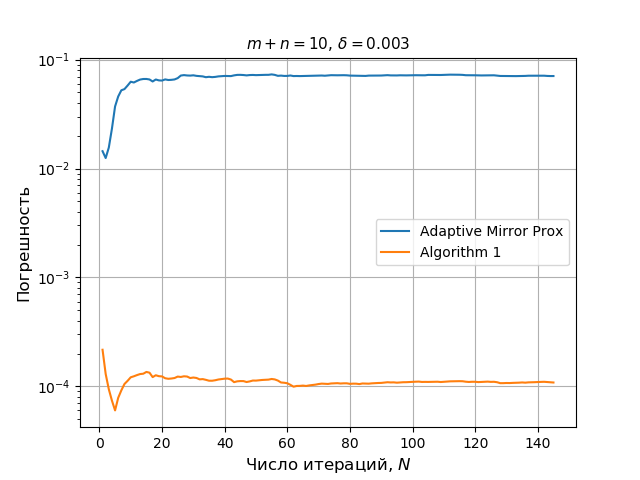

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, N1 + 1), plt1, label = 'Adaptive Mirror Prox')
plt.plot(range(1, N2 + 1), plt2, label = 'Algorithm 1')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Число итераций, $N$", fontsize=12)
plt.ylabel(r"Погрешность", fontsize=12)
plt.title(r"$m + n = 10, \, \delta = 0.003$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()